In [1]:
import matplotlib.pyplot as plt
from  matplotlib import style
import math as m
import pandas as pd
import numpy as np
import pandas_datareader.data as data

## Binomial and Convergence Rates

In [4]:
r = 0.05
sd = 0.24
S0 = 32
K = 30
T = 0.5

n = [10, 20, 40, 80, 100, 200, 500]

def stockBinomial(u, d, S0, n):
    stockT = [np.array([S0])]
    for i in range(n):
        current_S = stockT[-1]
        stockt = np.concatenate((current_S*u, [current_S[-1]*d]))
        stockT.append(stockt)
            
    return stockT[-1]

In [5]:
def EuropeanCalloption(u,d,p, r, S0, T, K, n):
    dt = T/n
    S_binomial = stockBinomial(u, d, S0, n)

    payoffs = np.maximum(S_binomial - K, 0)
    for i in range(n):
        payoffs = (payoffs[:-1]*p + payoffs[1:]*(1-p))/(m.exp(r*dt))
    return payoffs[0]

In [6]:
def get_parameters_a(r, sd, n, T):
    dt = T/n
    c = (1/2)*(m.exp(-r*dt) + m.exp((r + sd**2)*dt))
    d = c - m.sqrt(c**2 - 1)
    u = 1/d
    p = (m.exp(r*dt) - d)/(u - d)
    
    return u, d, p, n

In [16]:
a_parameters= [get_parameters_a(r, sd, n, T) for n in n]
a_call_values = [EuropeanCalloption(i[0], i[1], i[2],r, S0, T, K, i[3]) for i in a_parameters]
a_call_values

[3.7699443950589977,
 3.726137863594085,
 3.726147384390371,
 3.7268800790114147,
 3.721625972076113,
 3.72427602607829,
 3.722966608177395]

In [18]:
def get_parameters_b(r, sd, n, T):
    
    dt = T/n
    
    u = m.exp(r*dt)*(1 + m.sqrt(m.exp(sd**2 * dt) - 1))
    d = m.exp(r*dt)*(1 - m.sqrt(m.exp(sd**2 * dt) - 1))
    
    p = 1/2
    
    return u, d, p, n

b_parameters = [get_parameters_b(r, sd, n, T) for n in n]
b_call_values = [EuropeanCalloption(i[0], i[1], i[2], r, S0, T, K, i[3]) for i in b_parameters]

In [19]:
def get_parameters_c(r, sd, n, T):
    
    dt = T/n
    
    u = m.exp((r - 0.5*sd**2)*dt + sd*m.sqrt(dt))
    d = m.exp((r - 0.5*sd**2)*dt - sd*m.sqrt(dt))
    
    p = 1/2
    
    return u, d, p, n

c_parameters = [get_parameters_c(r, sd, n, T) for n in n]
c_call_values = [EuropeanCalloption(i[0], i[1], i[2], r, S0, T, K, i[3]) for i in c_parameters]

In [20]:
def get_parameters_d(r, sd, n, T):
    
    dt = T/n
    
    u = m.exp(sd*m.sqrt(dt))
    d = m.exp(- sd*m.sqrt(dt))
    
    p = 1/2 + (1/2)*((r - 0.5*sd**2)*m.sqrt(dt) / sd)
    
    return u, d, p, n

d_parameters = [get_parameters_d(r, sd, n, T) for n in n]
d_call_values = [EuropeanCalloption(i[0], i[1], i[2], r, S0, T, K, i[3]) for i in d_parameters]

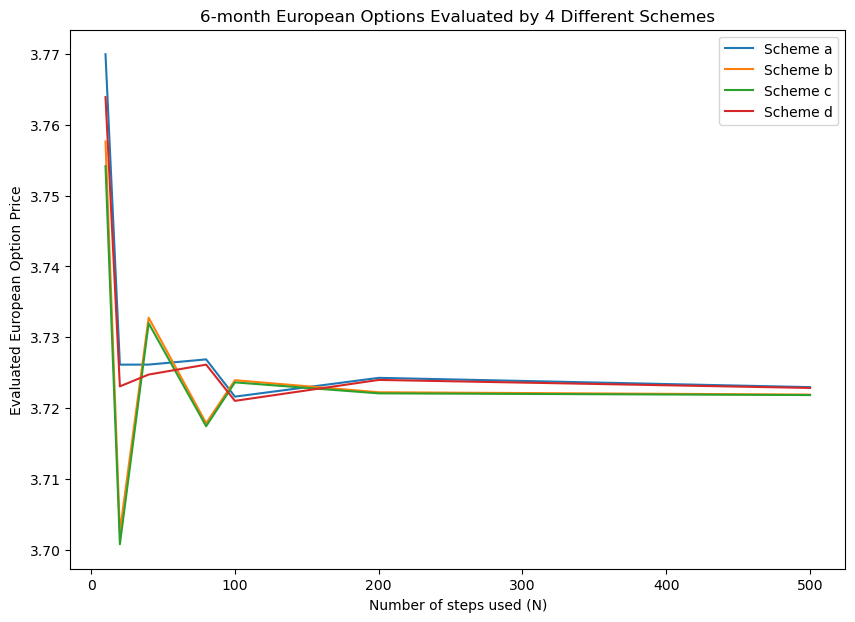

In [21]:
a = zip(n, a_call_values)
b = zip(n, b_call_values)
c = zip(n, c_call_values)
d = zip(n, d_call_values)

plt.figure(figsize=(10,7))

plt.plot(*zip(*a), label="Scheme a")
plt.plot(*zip(*b), label = "Scheme b")
plt.plot(*zip(*c), label = "Scheme c")
plt.plot(*zip(*d), label = "Scheme d")
plt.title("6-month European Options Evaluated by 4 Different Schemes")
plt.xlabel("Number of steps used (N)")
plt.ylabel("Evaluated European Option Price")
plt.legend()
plt.show()

## Pricing Google option

In [24]:
start_date = '2013-01-19'
end_date = '2018-01-19'

api_key = 'YM8zhsM2pmqRMemHD6ud'

google_prices = data.DataReader('GOOG', 'quandl', start_date, end_date, api_key=api_key).dropna(axis=1, how='all')
GOOGLE_returns = google_prices['AdjClose']/google_prices['AdjClose'].shift(1) - 1
GOOGLE_sd_daily = np.std(GOOGLE_returns)

GOOGLE_sd = GOOGLE_sd_daily*m.sqrt(252)

def EuroCalloption(r, sd, So, T, K, n):
    dt = T/n
    u = m.exp((r - 0.5*sd**2)*dt + sd*m.sqrt(dt))
    d = m.exp((r - 0.5*sd**2)*dt - sd*m.sqrt(dt))
    p = (m.exp(r*dt) - d)/ (u - d)

    dt = T/n
    S_binomial = stockBinomial(u, d, S0, n)
    payoffs = np.maximum(S_binomial-K, 0)
    for i in range(n):
        payoffs = (payoffs[:-1]*p + payoffs[1:]*(1-p))/(m.exp(r*dt))

    return payoffs[0]

In [48]:
r = 0.02
T = 1
n = 365
S0 =  round(google_prices['AdjClose']['2018-01-19'], 1)
K = (1.1*S0)// 10 * 10

call_1yr = EuropeanCalloption(r, GOOGLE_sd, S0, T, K, n)

In [51]:
def implied_volatility_eurocall(r, S0, C0, T, K, n):
    implied_vol = 0.155
    C = EuropeanCalloption(r, implied_vol, S0, T, K, n)
    while(C0-C)>.1:
        implied_vol +=.001
        C = EuropeanCalloption(r, implied_vol, S0, T, K, n)
    return round(implied_vol, 4)

C0 = 42.07
print(implied_volatility_eurocall(r, S0, C0, T, K, n))

## Pricing American Option using Binomial Model

In [52]:
def stockBinomial_am(u, d, S0, n):
    
    stockT = [np.array([S0])] 
    
    for i in range(n):
        current_S = stockT[-1]
        stockt = np.concatenate((current_S*u, [current_S[-1]*d]))
        stockT.append(stockt)
            
    return stockT

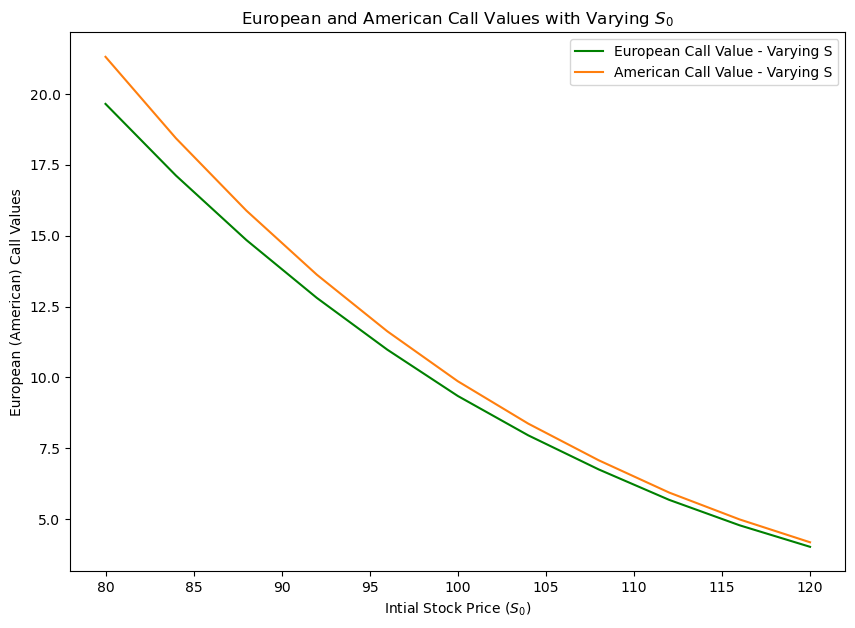

In [53]:
def EuropeanPutOption(r, sd, S0, T, K, n):
    
    # find u, d and p
    dt = T/n
    u = m.exp((r - 0.5*sd**2)*dt + sd*m.sqrt(dt))
    d = m.exp((r - 0.5*sd**2)*dt - sd*m.sqrt(dt))
    p = (m.exp(r*dt) - d)/ (u - d)

    # build stock tree and payoff tree
    S_binomial = stockBinomial(u, d, S0, n)
    
    # initialize payoffs
    payoffs = np.maximum(K - S_binomial, 0)

    # find the call option value  
    for i in range(n):
        payoffs = (payoffs[:-1] * p + payoffs[1:] * (1 - p))/(m.exp(r*dt))
            
    return payoffs[0]

def AmericanPutOption(r, sd, S0, T, K, n):
    
    # find u, d and p
    dt = T/n
    u = m.exp((r - 0.5*sd**2)*dt + sd*m.sqrt(dt))
    d = m.exp((r - 0.5*sd**2)*dt - sd*m.sqrt(dt))
    p = (m.exp(r*dt) - d)/ (u - d)
    
    # build stock tree and payoff tree
    S_binomial = stockBinomial_am(u, d, S0, n)
    
    # initialize payoffs
    payoffs = np.maximum(K - S_binomial[-1], 0)

    # find the call option value  
    for i in reversed(range(n)):
        payoffs = np.maximum((payoffs[:-1] * p + payoffs[1:] * (1 - p))/(m.exp(r*dt)), 
                             np.maximum(K - S_binomial[i], 0))
                              
    return payoffs[0]

K = 100
sd = 0.3
r = 0.05
n = 120
T = 1
S0_range2 = list(range(80, 121, 4))

european_call_vals = [EuropeanPutOption(r, sd, S0_range2[i], T, K, n) for i in range(len(S0_range2))]
American_call_vals = [AmericanPutOption(r, sd, S0_range2[i], T, K, n) for i in range(len(S0_range2))]
eurocall = list(zip(S0_range2, european_call_vals))
amcall = list(zip(S0_range2, American_call_vals))
plt.figure(figsize=(10,7))
plt.plot(*zip(*eurocall), label="European Call Value - Varying S", color = 'g')
plt.plot(*zip(*amcall), label="American Call Value - Varying S", color = 'C1')
plt.title("European and American Call Values with Varying $S_0$")
plt.xlabel("Intial Stock Price ($S_0$)")
plt.ylabel("European (American) Call Values")
plt.legend()
plt.show()

## Trinomial Model

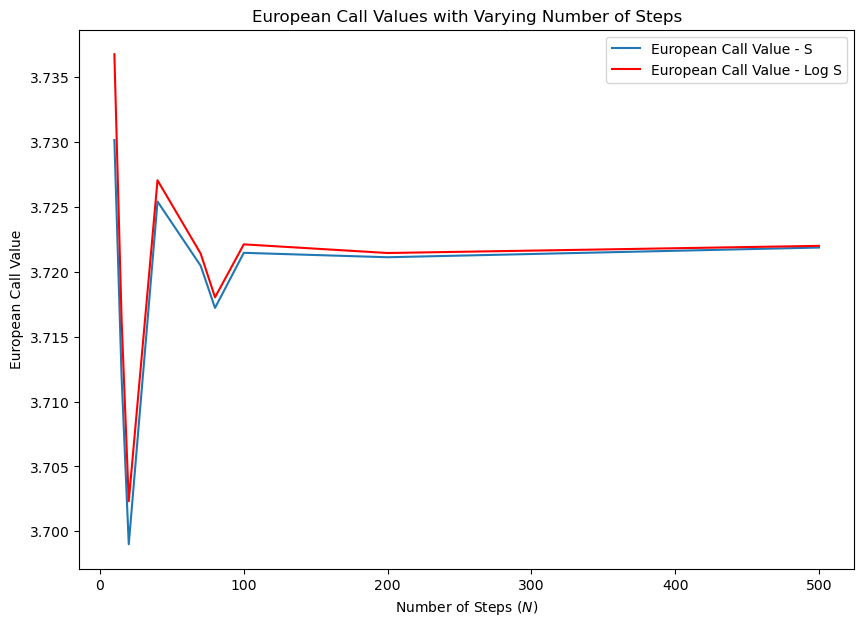

In [56]:
def stockTrinomial(r, u, d, mid, S0, T, n):

    stockT = [np.array([S0])] 
    
    for i in range(n):
        current_S = stockT[-1]
        stockt = np.concatenate((current_S*u, [current_S[-1]*mid,
                                               current_S[-1]*d]))
        stockT.append(stockt)
                                
    return stockT[-1]  

def EuropeanTrinomial_S(r, sd, S0, T, K, n):
    
    dt = T/n
    
    # up, down and middle
    d = m.exp(-sd*m.sqrt(3*dt))
    u = 1/d
    mid = 1

    # find risk-neutral probability, pu, pd, pm
    pu = (r*dt*(1-d) + (r*dt)**2 + sd**2 *dt)/((u - d)*(u - 1))
    pd = (r*dt*(1-u) + (r*dt)**2 + sd**2 *dt)/((u - d)*(1 - d))
    pm = 1 - pu - pd
    
    # Find last period stock price 
    S_trinomial =  stockTrinomial(r, u, d, mid, S0, T, n)
    
    # initialize payoffs
    payoffs = np.maximum(S_trinomial - K, 0)

    # find the call option value  
    for i in range(n):
        payoffs = (payoffs[:-2] * pu + payoffs[1:-1] * pm + payoffs[2:] * pd)/(m.exp(r*dt))
    
    return payoffs[0]

T = 1/2
sd = 0.24
r = 0.05
S0 = 32
K =  30
N = [10, 15, 20, 40, 70, 80, 100, 200, 500]

calls_trinomial_S = [EuropeanTrinomial_S(r, sd, S0, T, K, i) for i in N]

def logStockTrinomial(r, dXu, dXd, dXm, X0, T, n):

    log_stockT = [np.array([X0])] 
    
    
    for i in range(n):
        current_X = log_stockT[-1]
        
        log_stockt = np.concatenate((current_X + dXu, 
                                     [current_X[-1] + dXm, current_X[-1] + dXd]))

        log_stockT.append(log_stockt)
                                
    return log_stockT[-1]  

def EuropeanTrinomial_logS(r, sd, S0, T, K, n):
    
    dt = T/n
    X0 = m.log(S0)
    
    # up, down and middle
    dXu = sd*m.sqrt(3*dt)
    dXd = -sd*m.sqrt(3*dt)
    dXm = 0

    # find risk-neutral probability, pu, pd, pm
    pu = (1/2)*(((r - 0.5*sd**2)**2 *(dt)**2 + sd**2 *dt)/(dXu)**2 + ((r - 0.5*sd**2)*dt)/dXu)
    pd = (1/2)*(((r - 0.5*sd**2)**2 *(dt)**2 + sd**2 *dt)/(dXu)**2 - ((r - 0.5*sd**2)*dt)/dXu)
    pm = 1 - pu - pd
    
    # Find last period stock price 
    logS_trinomial =  logStockTrinomial(r, dXu, dXd, dXm, X0, T, n)
    
    # initialize payoffs
    payoffs = np.maximum(np.exp(logS_trinomial) - K, 0)

    # find the call option value  
    for i in range(n):
        payoffs = (payoffs[:-2] * pu + payoffs[1:-1] * pm + payoffs[2:] * pd)/(m.exp(r*dt))
    
    return payoffs[0]

calls_trinomial_logS = [EuropeanTrinomial_logS(r, sd, S0, T, K, i) for i in N]

calls_trinomial_S = zip(N, calls_trinomial_S)
calls_trinomial_logS = zip(N, calls_trinomial_logS)
plt.figure(figsize=(10,7))
plt.plot(*zip(*calls_trinomial_S), label="European Call Value - S", color = 'C0')
plt.plot(*zip(*calls_trinomial_logS), label="European Call Value - Log S", color = 'r')
plt.title("European Call Values with Varying Number of Steps")
plt.xlabel("Number of Steps ($N$)")
plt.ylabel("European Call Value")
plt.legend()
plt.show()

## Halton Sequence for Pricing Options

In [57]:
def Halton_1D(size, base):
    sequence = []
    for i in range(size + 1):
        k, m = 0., 1.
        while i > 0:
            i, a = (i // base, i % base)
            m *= base
            k += a / m
        sequence.append(k)
    return sequence

def Halton_2D(size, b1, b2):
    
    halton_x = Halton_1D(size, b1)[1:]
    halton_y = Halton_1D(size, b2)[1:]

    return halton_x, halton_y 

def normals_from_Halton(size, b1, b2):
    
    # Generate Halton Sequence and use them as uniform random samples
    U1, U2 = Halton_2D(size//2, b1, b2)
    # Generate random normal samples with Box-Muller Algorithm
    Z1 = list(map(lambda u1, u2: m.sqrt(-2*m.log(u1)) * m.cos(2*m.pi*u2), U1, U2))
    Z2 = list(map(lambda u1, u2: m.sqrt(-2*m.log(u1)) * m.sin(2*m.pi*u2), U1, U2))
    
    return np.asarray(Z1 + Z2)

def EuropeanCallHalton(r, sd, S0, T, K, n, b1, b2):
    
    # generate normal from Halton Sequence
    Zt = normals_from_Halton(n, b1, b2)
    # Simulate Stock prices at time T
    ST = S0*np.exp((r - 0.5*sd**2)*T + sd*np.sqrt(T)*Zt)
    
    # Find call option value
    payoffs = np.maximum(ST - K, 0)
    
    C = m.exp(-r*T)* np.mean(payoffs)
    
    return C

# Define parameters
r = 0.05
sd = 0.24
S0 = 32
K = 30
T = 0.5
n = 1000
b1 = 2
b2 = 7
print("The price of the European Call option found by Halton Sequence: $", EuropeanCallHalton(r, sd, S0, T, K, n, b1, b2))

The price of the European Call option found by Halton Sequence: $ 3.7365649844322957
